In [79]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir
import uproot
import root_pandas
%load_ext jupyternotify

import mplhep as hep
hep.style.use("CMS")

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [80]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

#import misc_util#correlation_plots

import R2h_module as r2h


In [219]:
import pickle as pkl
filename="mixed_tuples/mixed_no_ecuts_originalK_D_Pb.pkl"
with open(filename, 'rb') as f:
    df= pkl.load(f)

In [220]:
df.rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
df.rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
df = r2h.applyCuts(df,isMC=False, nomCuts=True)
df = r2h.applyCutsPair(df,isMC=False, nomCuts=True, h2Proton=True)

Entries before cut  2958670
Q2>1.0 and Q2<4.0 2958670  (100.00  %)
0.2<h1_p<5.0  2958670  (100.00  %)
inelasticity < 0.85 2897110  (97.92  %)
h1_pid = pions (trigger) 2897110  (100.00  %)
2.2 < nu <4.2 2862920  (98.82  %)
10< h1_th 2862920  (100.00  %)
Theta/P fiducial region selected for trigger hadron 2862920  (100.00  %)
Nom cuts for the trigger applied 1665670  (58.18  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 1665670  (100.00  %)
2.2 < nu < 4.2 1665670  (100.00  %)
secondary hadrons are protons 602098  (36.15  %)
leading hadrons are pions 602098  (100.00  %)
0.2<h2_p<5.0 438864  (72.89  %)
0.2<h1_p<5.0 438864  (100.00  %)
10<h2_th 438864  (100.00  %)
Theta/P fiducial region selected for secondary hadron 438864  (100.00  %)
10< h1_th 438864  (100.00  %)
Theta/P fiducial region selected for trigger hadron 438864  (100.00  %)
Nom cuts for the pair applied (pi p) 438864  (100.00  %)


In [221]:
def poly(a, coeffs):
    ret=0
    for i in range(len(coeffs)):
        ret=ret+coeffs[i]*a**i
    return ret
ecorr_pars={"C":[0.00205, 0.000217, 0.0913],
    "Fe": [0.00205, 0.000218, 0.0911],
    "Pb": [0.00205, 0.000218, 0.0912],
    "D": [0.00208, 0.000255, 0.0886]}

p=df.h2_p#eval("sqrt(h2_E**2-0.09383**2)")
T4=df.h2_T4
coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352
df['pass_proton_TOF_cut']=((p>0.2)&(p<0.8)&(T4<poly(p,coeffs_high_range1))&(T4>poly(p,coeffs_low_range1)))|\
              ((p>=0.8)&(p<2.8)&(T4<poly(p,coeffs_high_range2))&(T4>poly(p,coeffs_low_range2))) 

a='D'
#Or Hen had .0013, .00084,.074
df.eval(f"h2_p_corr=sqrt((sqrt(h2_p**2+.9383**2)+{ecorr_pars[a][0]}+{ecorr_pars[a][1]}/({ecorr_pars[a][2]}+h2_p)**2)**2-.9383**2)", inplace=True)
#df.eval("h2_cm_pt_corr=h2_p_corr/h2_p*h2_cm_pt", inplace=True)
df.eval("h2_cm_pt_corr=h2_p_corr/h2_p*sqrt(h2_p**2-(h2_px*(-mixevt_e_px)+h2_py*(-mixevt_e_py)+h2_pz*(mixevt_E-mixevt_e_pz))**2/(mixevt_e_px**2+mixevt_e_py**2+(mixevt_E-mixevt_e_pz)**2))",
        inplace=True)

df.eval("h2_rap_corr=(h2_rap+ycm)/abs(h2_rap+ycm)*0.5*log((sqrt(h2_p_corr**2+.9383**2)+sqrt(h2_p_corr**2-h2_cm_pt_corr**2))/"\
        +"(sqrt(h2_p_corr**2+.9383**2)-sqrt(h2_p_corr**2-h2_cm_pt_corr**2)))-ycm",inplace=True)
#df.eval("drap_corr=drap+h2_rap-h2_rap_corr", inplace=True)
df.eval("drap_corr=h1_rap-h2_rap_corr", inplace=True)    


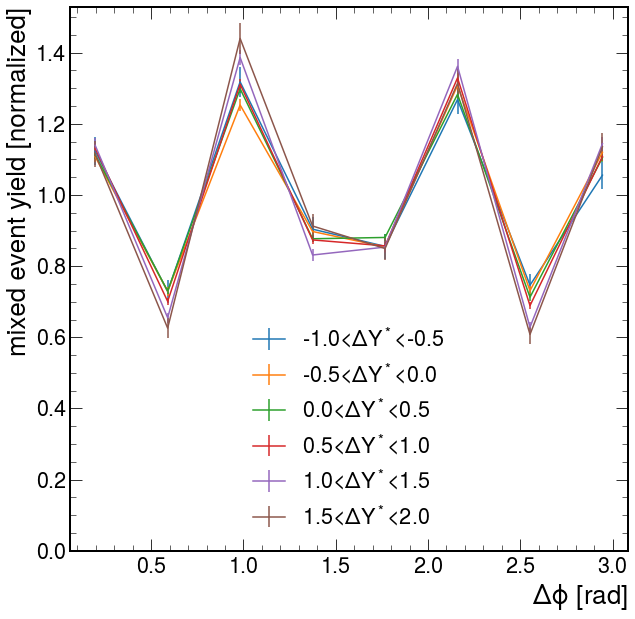

In [291]:
q = f"h1_pid==211 and "+\
                 f" h1_z>0.5 and h2_z>0.05 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"
q+=" and h1_cm_pt >0.07 and h2_cm_pt>0.07"
#q+=" and abs(e_ph-mixevt_e_ph)<.2 and abs(Q2-mixevt_Q2)<.2*Q2"
q+= " and sqrt(h2_p_corr**2+0.9383**2)-0.9383<0.5*mixevt_nu"
#q+= " and abs(h2_cm_ph)>0.4"
for i in range(6):
    dfq=df.query(q + f' and drap_corr-ycm>{i*.5-1} and drap_corr-ycm<{i*.5-.5}')
    dphi="abs(h1_cm_ph-h2_cm_ph-2*3.14159*(h1_cm_ph-h2_cm_ph>3.14159)+2*3.14159*(h1_cm_ph-h2_cm_ph<-3.14159))"
    dphi="abs(diff_phi_lab)"
    y, x=np.histogram(dfq.eval(dphi), range=(0, np.pi), bins=8)
    bc=(x[1:]+x[:-1])/2
    dy=np.sqrt(y)
    plt.errorbar(bc, y*len(y)/sum(y), dy*len(y)/sum(y), label=f'{i*.5-1:.1f}<$\\Delta Y^*$<{i*.5-.5:.1f}')
plt.xlabel("$\\Delta\\phi$ [rad]")
plt.ylabel("mixed event yield [normalized]")
plt.ylim(0)
plt.legend()

(array([53367., 29450., 43053., 59786., 34475., 34370., 59581., 42593.,
        29169., 53020.]),
 array([6.92421883e-06, 3.14164765e-01, 6.28322605e-01, 9.42480446e-01,
        1.25663829e+00, 1.57079613e+00, 1.88495397e+00, 2.19911181e+00,
        2.51326965e+00, 2.82742749e+00, 3.14158533e+00]),
 <BarContainer object of 10 artists>)

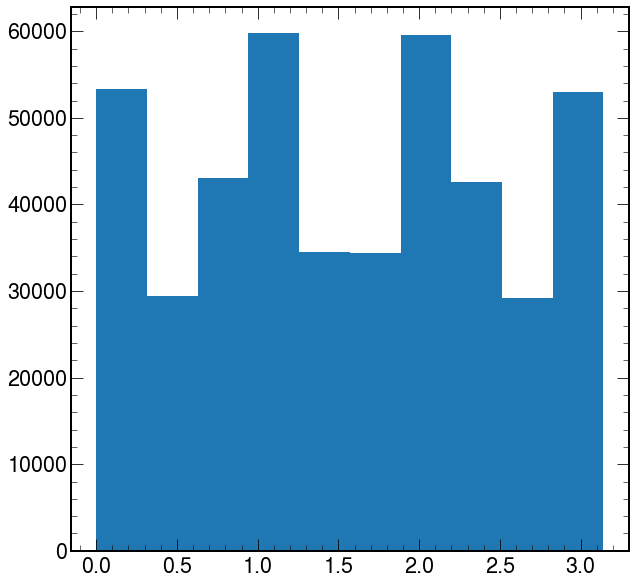

In [269]:
plt.hist(np.abs(df.diff_phi_lab))

Text(0, 1, '$\\phi_p$ [rad]')

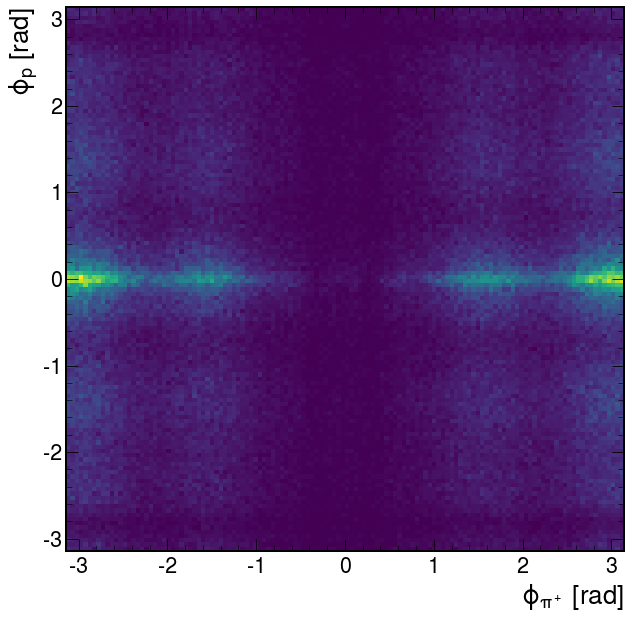

In [255]:
q = f"h1_pid==211 and h1_cm_pt > 0.07 and "+\
                 f"h2_cm_pt_corr > 0.07 and h1_z>0.5 and h2_z>0.05 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"
q+= " and sqrt(h2_p_corr**2+0.9383**2)-0.9383<0.5*mixevt_nu"
plt.hist2d(df.query(q).eval("h1_cm_ph"), df.query(q).eval("h2_cm_ph"), bins=128)
plt.xlabel("$\\phi_{\\pi^+}$ [rad]")
plt.ylabel("$\\phi_p$ [rad]")

Text(0, 1, '$\\phi_p$ [rad]')

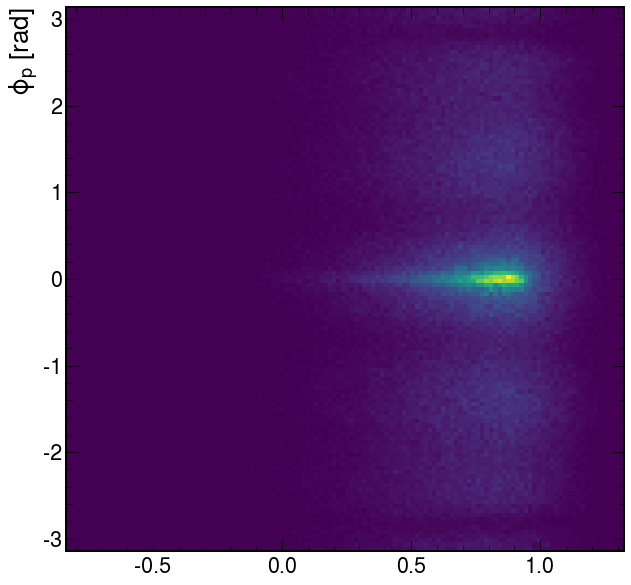

In [262]:
q = f"h1_pid==211 and h1_cm_pt > 0.07 and "+\
                 f"h2_cm_pt_corr > 0.07 and h1_z>0.5 and h2_z>0.05 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"
q+= " and sqrt(h2_p_corr**2+0.9383**2)-0.9383<0.5*mixevt_nu"
#b+d-e'-p'
f="(mixevt_E-mixevt_e_p+1.875-sqrt(h2_p_corr**2+0.9383**2))**2-(-mixevt_e_px-h2_px*h2_p_corr/h2_p)**2-(-mixevt_e_py-h2_py*h2_p_corr/h2_p)**2-(mixevt_E-mixevt_e_pz-h2_pz*h2_p_corr/h2_p)**2"
#b+p-e'-p'
f="(mixevt_E-mixevt_e_p+.9383-sqrt(h2_p_corr**2+0.9383**2))**2-(-mixevt_e_px-h2_px*h2_p_corr/h2_p)**2-(-mixevt_e_py-h2_py*h2_p_corr/h2_p)**2-(mixevt_E-mixevt_e_pz-h2_pz*h2_p_corr/h2_p)**2"

#E(b+d-e'-p'-n')
#\vec n'=\vec(b-e'-p')
f="mixevt_E-mixevt_e_p+1.875-sqrt(h2_p_corr**2+0.9383**2)-sqrt((-mixevt_e_px-h2_px*h2_p_corr/h2_p)**2+(-mixevt_e_py-h2_py*h2_p_corr/h2_p)**2+(mixevt_E-mixevt_e_pz-h2_pz*h2_p_corr/h2_p)**2+.9406**2)"


plt.hist2d(df.query(q).eval(f), df.query(q).eval("h2_cm_ph"), bins=128)
#plt.xlabel("$\\phi_{\\pi^+}$ [rad]")
plt.ylabel("$\\phi_p$ [rad]")

(array([21798., 24391., 24620., 22691., 19184., 14813.,  9798.,  5058.,
         1276.,   102.]),
 array([2.00000596, 2.09115956, 2.18231316, 2.27346675, 2.36462035,
        2.45577395, 2.54692755, 2.63808115, 2.72923474, 2.82038834,
        2.91154194]),
 <BarContainer object of 10 artists>)

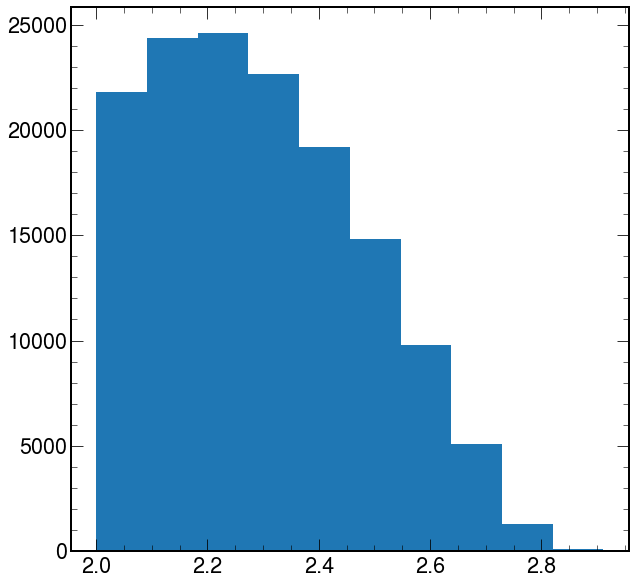

In [218]:
plt.hist(df.query(q).mixevt_W)

(array([3.009e+03, 4.046e+03, 4.650e+03, 5.363e+03, 5.637e+03, 6.319e+03,
        7.012e+03, 7.195e+03, 7.561e+03, 7.950e+03, 8.187e+03, 8.251e+03,
        8.374e+03, 8.148e+03, 8.140e+03, 8.029e+03, 7.774e+03, 7.385e+03,
        7.016e+03, 6.901e+03, 6.449e+03, 5.635e+03, 4.790e+03, 4.225e+03,
        3.794e+03, 3.588e+03, 3.637e+03, 3.921e+03, 4.042e+03, 4.013e+03,
        4.060e+03, 3.996e+03, 3.725e+03, 3.457e+03, 3.276e+03, 3.215e+03,
        3.185e+03, 3.070e+03, 3.022e+03, 3.044e+03, 2.964e+03, 2.899e+03,
        2.648e+03, 2.397e+03, 2.244e+03, 2.093e+03, 1.737e+03, 1.519e+03,
        1.331e+03, 1.095e+03, 9.280e+02, 7.400e+02, 6.630e+02, 5.960e+02,
        4.780e+02, 4.520e+02, 3.990e+02, 3.570e+02, 3.260e+02, 2.970e+02,
        2.880e+02, 2.630e+02, 1.860e+02, 1.680e+02, 1.600e+02, 1.770e+02,
        1.590e+02, 1.700e+02, 1.280e+02, 1.190e+02, 1.200e+02, 9.800e+01,
        1.040e+02, 8.300e+01, 7.400e+01, 5.500e+01, 4.500e+01, 4.600e+01,
        6.400e+01, 5.300e+01, 5.000e+0

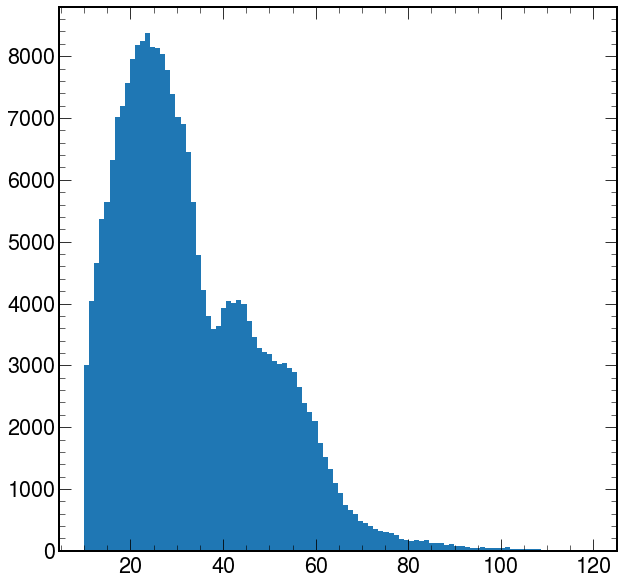

In [152]:
plt.hist(df.query(q).h2_th, bins=100)

(array([2.1000e+01, 9.4500e+02, 1.5919e+04, 6.4799e+04, 9.6564e+04,
        6.7712e+04, 3.5186e+04, 1.1481e+04, 1.0070e+03, 3.7000e+01]),
 array([-2.30441283, -1.76700261, -1.22959239, -0.69218217, -0.15477194,
         0.38263828,  0.9200485 ,  1.45745873,  1.99486895,  2.53227917,
         3.0696894 ]),
 <BarContainer object of 10 artists>)

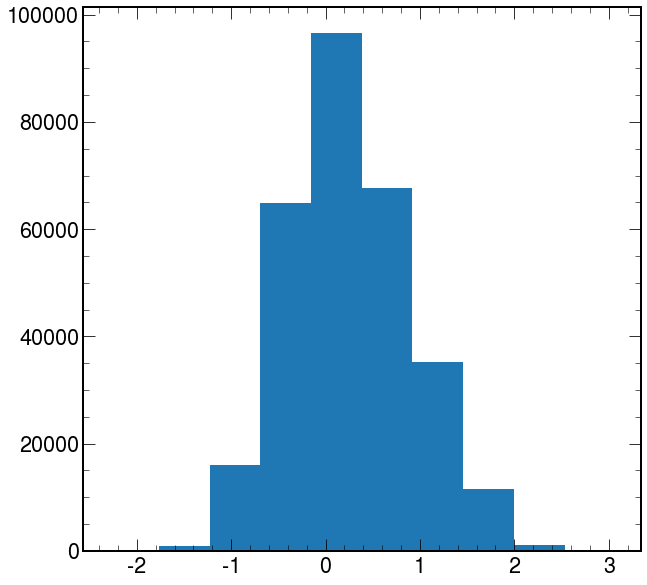

In [85]:
plt.hist(df.eval("drap_corr-ycm"))

(array([1.2109e+04, 4.6056e+04, 5.2079e+04, 4.2539e+04, 2.7131e+04,
        1.3258e+04, 5.0840e+03, 1.5220e+03, 2.8200e+02, 4.4000e+01]),
 array([0.73727574, 0.86292861, 0.98858147, 1.11423433, 1.2398872 ,
        1.36554006, 1.49119292, 1.61684579, 1.74249865, 1.86815151,
        1.99380437]),
 <BarContainer object of 10 artists>)

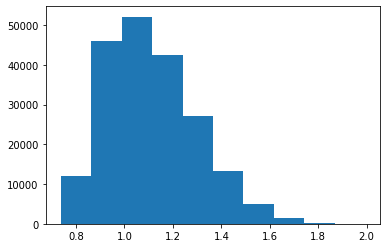

In [49]:
plt.hist(dfq.eval("h1_z+h2_z"))

In [91]:
df.columns

Index(['E', 'mixevt_E', 'e_p', 'mixevt_e_p', 'e_th', 'mixevt_e_th', 'e_ph',
       'mixevt_e_ph', 'h1_pid', 'h2_pid', 'h1_xf', 'h2_xf', 'h1_xf_default',
       'h2_xf_default', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt', 'h1_rap',
       'h2_rap', 'h1_cm_rap', 'h2_cm_rap', 'Q2', 'mixevt_Q2', 'x', 'mixevt_x',
       'nu', 'mixevt_nu', 'W', 'mixevt_W', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th',
       'TargType', 'missing_mass', 'h1_ph', 'h2_ph', 'h1_th', 'h2_th', 'h1_p',
       'h2_p', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe', 'h1_Sector',
       'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'h1_T4', 'h2_T4', 'SampFracEl25',
       'SampFracEl20', 'ycm', 'mixevt_ycm', 'z', 'e_px', 'mixevt_e_px', 'e_py',
       'mixevt_e_py', 'e_pz', 'mixevt_e_pz', 'y', 'mixevt_y', 'h1_px', 'h2_px',
       'h1_py', 'h2_py', 'h1_pz', 'h2_pz', 'q_th', 'mixevt_q_th',
       'mixevt_nskipped', 'diff_phi_cm', 'diff_phi_lab', 'diff_rap_cm',
       'mx_

In [272]:
for x in "xyz":
    df.eval(f"e_avg_p{x}=(e_px+mixevt_e_p{x})/2",inplace=True)
df.eval(f"avg_qx=-e_avg_px",inplace=True)
df.eval(f"avg_qy=-e_avg_py",inplace=True)
df.eval(f"avg_qz=E-e_avg_pz",inplace=True)
df.eval("avg_q=sqrt(avg_qx**2+avg_qy**2+avg_qz**2)", inplace=True)
df.eval(f"avg_ycm=0.5*log((E-sqrt(e_avg_px**2+e_avg_py**2+e_avg_pz**2)+0.938+avg_q)/(E-sqrt(e_avg_px**2+e_avg_py**2+e_avg_pz**2)+0.938-avg_q))", inplace=True)

In [273]:
def phi_rap(df,q,v, m):
    vx=df.eval(v)
    vy=df.eval(v.replace('x','y'))
    vz=df.eval(v.replace('x','z'))

    qx=df.eval(q)
    qy=df.eval(q.replace('x','y'))
    qz=df.eval(q.replace('x','z'))
    dphi=np.arctan2(qy,qx)
    dtheta=np.arctan2(np.hypot(qx,qy), qz)
    vxp=vx*np.cos(dphi)+vy*np.sin(dphi)
    vyp=vy*np.cos(dphi)-vx*np.sin(dphi)
    vzp=vz

    vxpp=vxp*np.cos(dtheta)-vzp*np.sin(dtheta)
    vypp=vyp
    vzpp=vzp*np.cos(dtheta)+vxp*np.sin(dtheta)
    E=np.sqrt(vx**2+vy**2+vz**2+m**2)
    return np.arctan2(vypp,vxpp), 0.5*np.log((E+vzpp)/(E-vzpp))
    

In [274]:
df['phi1'],df['rap1']=phi_rap(df,"avg_qx", "h1_px", 0.1396)
df['phi2'],df['rap2']=phi_rap(df,"avg_qx", "h2_px*h2_p_corr/h2_p", 0.9383)

In [275]:
df['dphi_alt']=df.eval('phi1-phi2+2*3.14159*(phi1-phi2<-3.14159)-2*3.14159*(phi1-phi2>3.14159)')
df['drap_alt']=df.eval('rap1-rap2')

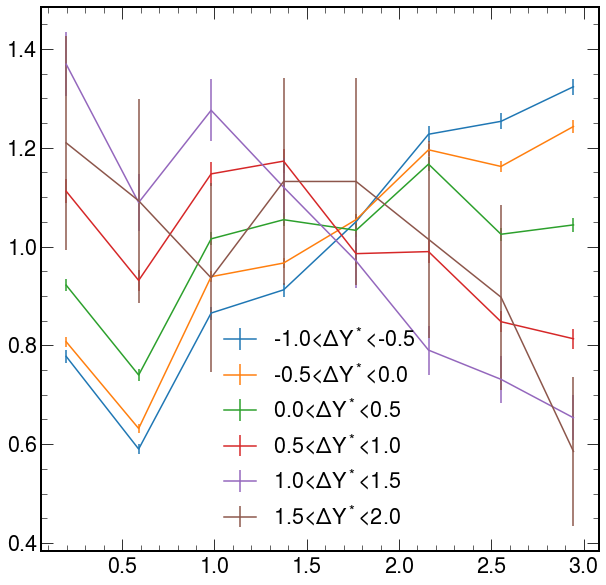

In [288]:
ptmin=0.07
q = f"h1_pid==211  "+\
                 f" and h1_z>0.5 and h2_p>0.05 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"
q+=" and abs(e_ph-mixevt_e_ph)<10"# and abs(Q2-mixevt_Q2)<.3*Q2"
for i in range(6):
    dfq=df.query(q+ f' and drap_alt-avg_ycm>{i*.5-1} and drap_alt-avg_ycm<{i*.5-.5}')
    y, x=np.histogram(dfq.dphi_alt, range=(0, np.pi), bins=8)
    bc=(x[1:]+x[:-1])/2
    dy=np.sqrt(y)
    plt.errorbar(bc, y*len(y)/sum(y), dy*len(y)/sum(y), label=f'{i*.5-1:.1f}<$\\Delta Y^*$<{i*.5-.5:.1f}')
plt.legend()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.47826346, -1.44769517, -1.41712688, -1.38655858, -1.35599029,
        -1.325422  , -1.2948537 , -1.26428541, -1.23371712, -1.20314882,
        -1.17258053, -1.14201224, -1.11144394, -1.08087565, -1.05030736,
        -1.01973906, -0.98917077, -0.95860248, -0.92803419, -0.89746589,
        -0.8668976 , -0.83632931, -0.80576101, -0.77519272, -0.74462443,
        -0.71405613, -0.68348784, -0.65291955, -0.62235125, -0.59178296,
        -0.56121467, -0.53064637, -0.50007808, -0.46950979, -0.43894149,
        -0.4083732 , -0.37780491, -0.34723661, -0.31666832, -0.28610003,
        -0.25553173, -0.22496344, -0.19439515, -0.16382685, -0.13325856,
        -0.10269027, -0.07212197, -0.04155368, -0.01098539,  0.01958291,
         0.0501512 , 

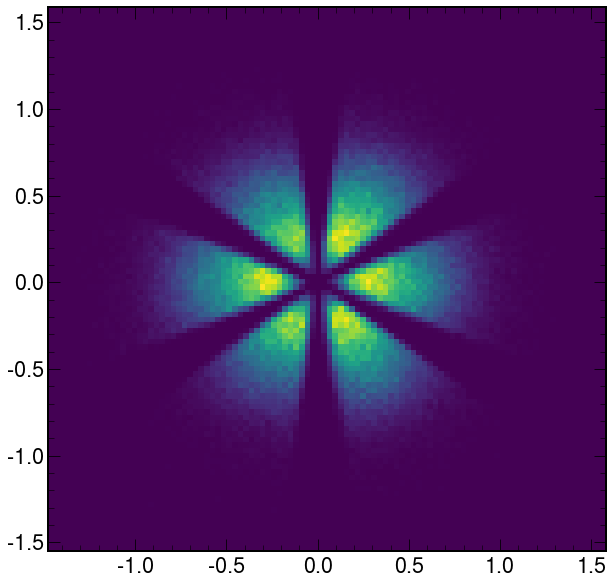

In [113]:
plt.hist2d(df.eval('h2_px'), df.eval('h2_py'), bins=100)

(array([ 76248., 116645.,  82421.,  29766.,   5726.,    614.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <BarContainer object of 6 artists>)

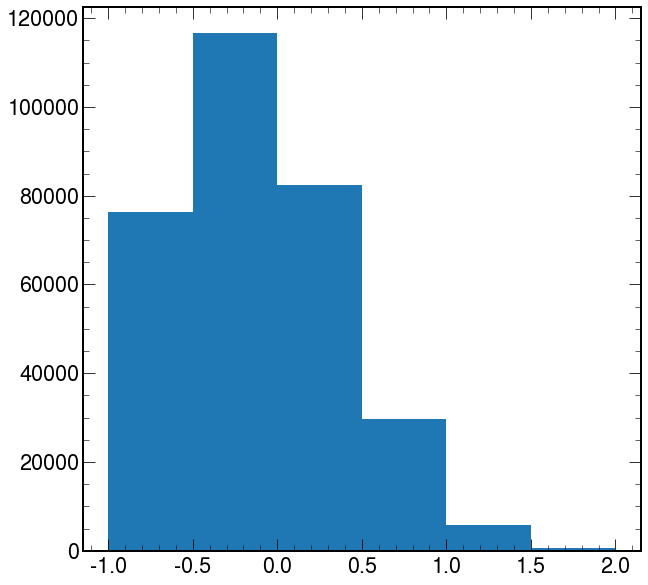

In [130]:
plt.hist(df.eval("drap_alt-avg_ycm"), bins=6, range=(-1,2))

In [174]:
df.columns

Index(['E', 'mixevt_E', 'e_p', 'mixevt_e_p', 'e_th', 'mixevt_e_th', 'e_ph',
       'mixevt_e_ph', 'h1_pid', 'h2_pid', 'h1_xf', 'h2_xf', 'h1_xf_default',
       'h2_xf_default', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt', 'h1_rap',
       'h2_rap', 'h1_cm_rap', 'h2_cm_rap', 'Q2', 'mixevt_Q2', 'x', 'mixevt_x',
       'nu', 'mixevt_nu', 'W', 'mixevt_W', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th',
       'TargType', 'missing_mass', 'h1_ph', 'h2_ph', 'h1_th', 'h2_th', 'h1_p',
       'h2_p', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe', 'h1_Sector',
       'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'h1_T4', 'h2_T4', 'SampFracEl25',
       'SampFracEl20', 'ycm', 'mixevt_ycm', 'z', 'e_px', 'mixevt_e_px', 'e_py',
       'mixevt_e_py', 'e_pz', 'mixevt_e_pz', 'y', 'mixevt_y', 'h1_px', 'h2_px',
       'h1_py', 'h2_py', 'h1_pz', 'h2_pz', 'q_th', 'mixevt_q_th',
       'mixevt_nskipped', 'diff_phi_cm', 'diff_phi_lab', 'diff_rap_cm',
       'mx_

(array([2.000e+00, 2.000e+00, 8.000e+00, 1.200e+01, 1.700e+01, 3.400e+01,
        4.900e+01, 9.400e+01, 1.570e+02, 2.300e+02, 4.030e+02, 6.020e+02,
        9.540e+02, 1.462e+03, 2.009e+03, 2.580e+03, 3.353e+03, 4.151e+03,
        4.978e+03, 5.866e+03, 6.721e+03, 7.532e+03, 7.995e+03, 8.293e+03,
        8.588e+03, 8.721e+03, 8.693e+03, 8.637e+03, 8.476e+03, 8.169e+03,
        7.838e+03, 7.551e+03, 7.030e+03, 6.738e+03, 6.323e+03, 5.909e+03,
        5.436e+03, 5.033e+03, 4.545e+03, 4.077e+03, 3.624e+03, 3.277e+03,
        2.984e+03, 2.533e+03, 2.365e+03, 2.084e+03, 1.799e+03, 1.590e+03,
        1.345e+03, 1.168e+03, 1.037e+03, 9.470e+02, 8.130e+02, 6.830e+02,
        5.750e+02, 5.310e+02, 4.800e+02, 4.330e+02, 3.080e+02, 2.580e+02,
        2.890e+02, 2.280e+02, 1.730e+02, 1.440e+02, 1.620e+02, 1.370e+02,
        1.090e+02, 8.200e+01, 7.000e+01, 6.800e+01, 6.300e+01, 4.200e+01,
        4.100e+01, 3.400e+01, 2.200e+01, 2.400e+01, 1.400e+01, 1.700e+01,
        1.000e+01, 1.700e+01, 8.000e+0

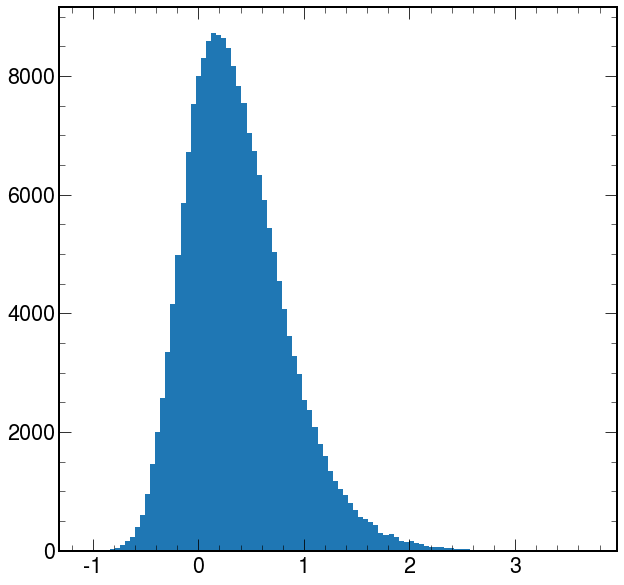

In [180]:
f="h2_p_corr/h2_p*sqrt(h2_p**2-(h2_px*(-mixevt_e_px)+h2_py*(-mixevt_e_py)+h2_pz*(mixevt_E-mixevt_e_pz))**2/(mixevt_e_px**2+mixevt_e_py**2+(mixevt_E-mixevt_e_pz)**2))"
plt.hist(df.eval(f+"-h2_cm_pt_corr"), bins=100)

In [ ]:
f="h2_p_corr/h2_p*sqrt(h2_p**2-(h2_px*(-mixevt_e_px)+h2_py*(-mixevt_e_py)+h2_pz*(mixevt_E-mixevt_e_pz))**2/(mixevt_e_px**2+mixevt_e_py**2+(mixevt_E-mixevt_e_pz)**2))"
plt.hist(df.eval(f+"-h2_cm_pt_corr"), bins=100)

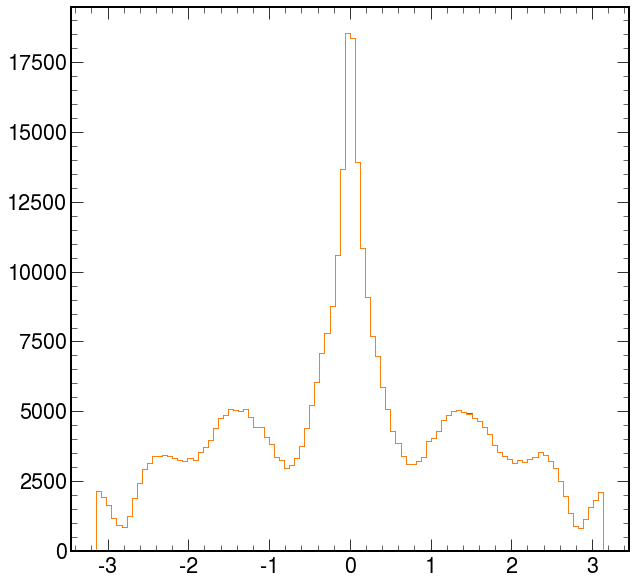

In [249]:
q = f"h1_pid==211 and h1_cm_pt > 0.07 and "+\
                 f"h2_cm_pt_corr > 0.07 and h1_z>0.5 and h2_z>0.05 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"

def phi_rap(df,q,v, m):
    vx=df.eval(v.replace('[]','x'))
    vy=df.eval(v.replace('[]','y'))
    vz=df.eval(v.replace('[]','z'))

    qx=df.eval(q.replace('[]','x'))
    qy=df.eval(q.replace('[]','y'))
    qz=df.eval(q.replace('[]','z'))
    dphi=np.arctan2(qy,qx)
    dtheta=np.arctan2(np.hypot(qx,qy), qz)
    vxp=vx*np.cos(dphi)+vy*np.sin(dphi)
    vyp=vy*np.cos(dphi)-vx*np.sin(dphi)
    vzp=vz

    vxpp=vxp*np.cos(dtheta)-vzp*np.sin(dtheta)
    vypp=vyp
    vzpp=vzp*np.cos(dtheta)+vxp*np.sin(dtheta)
    E=np.sqrt(vx**2+vy**2+vz**2+m**2)
    return np.arctan2(vypp,vxpp), 0.5*np.log((E+vzpp)/(E-vzpp))
df.eval("mixevt_qx=-mixevt_e_px", inplace=True)
df.eval("mixevt_qy=-mixevt_e_py", inplace=True)
df.eval("mixevt_qz=mixevt_E-mixevt_e_pz", inplace=True)
plt.hist(phi_rap(df, "mixevt_q[]", "h2_p[]", 0.9383)[0], bins=100, histtype='step')
plt.hist(df.h2_cm_ph, bins=100, histtype='step')
#plt.hist(phi_rap(df, "mixevt_q[]", "mixevt_e_p[]", 0.9383)[0], bins=100)
plt.show()

In [235]:
df.columns

Index(['E', 'mixevt_E', 'e_p', 'mixevt_e_p', 'e_th', 'mixevt_e_th', 'e_ph',
       'mixevt_e_ph', 'h1_pid', 'h2_pid', 'h1_xf', 'h2_xf', 'h1_xf_default',
       'h2_xf_default', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt', 'h1_rap',
       'h2_rap', 'h1_cm_rap', 'h2_cm_rap', 'Q2', 'mixevt_Q2', 'x', 'mixevt_x',
       'nu', 'mixevt_nu', 'W', 'mixevt_W', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th',
       'TargType', 'missing_mass', 'h1_ph', 'h2_ph', 'h1_th', 'h2_th', 'h1_p',
       'h2_p', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe', 'h1_Sector',
       'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'h1_T4', 'h2_T4', 'SampFracEl25',
       'SampFracEl20', 'ycm', 'mixevt_ycm', 'z', 'e_px', 'mixevt_e_px', 'e_py',
       'mixevt_e_py', 'e_pz', 'mixevt_e_pz', 'y', 'mixevt_y', 'h1_px', 'h2_px',
       'h1_py', 'h2_py', 'h1_pz', 'h2_pz', 'q_th', 'mixevt_q_th',
       'mixevt_nskipped', 'diff_phi_cm', 'diff_phi_lab', 'diff_rap_cm',
       'mx_

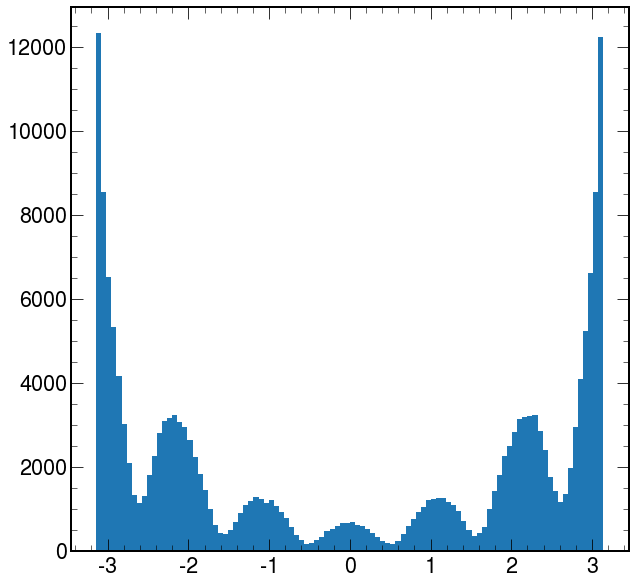

In [258]:
plt.hist(df.query(q).eval("mixevt_e_ph-h2_ph-2*3.14159*(mixevt_e_ph-h2_ph>3.14159)+2*3.14159*(mixevt_e_ph-h2_ph<-3.14159)"), bins=100)
plt.show()

# new version that uses an electron from a third event to get the electron direction

In [318]:
def poly(a, coeffs):
    ret=0
    for i in range(len(coeffs)):
        ret=ret+coeffs[i]*a**i
    return ret
ecorr_pars={"C":[0.00205, 0.000217, 0.0913],
    "Fe": [0.00205, 0.000218, 0.0911],
    "Pb": [0.00205, 0.000218, 0.0912],
    "D": [0.00208, 0.000255, 0.0886]}

p=df.h2_p#eval("sqrt(h2_E**2-0.09383**2)")
T4=df.h2_T4
coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352
df['pass_proton_TOF_cut']=((p>0.2)&(p<0.8)&(T4<poly(p,coeffs_high_range1))&(T4>poly(p,coeffs_low_range1)))|\
              ((p>=0.8)&(p<2.8)&(T4<poly(p,coeffs_high_range2))&(T4>poly(p,coeffs_low_range2))) 

a='D'

#Or Hen had .0013, .00084,.074
df.eval(f"h2_p_corr=sqrt((sqrt(h2_p**2+.9383**2)+{ecorr_pars[a][0]}+{ecorr_pars[a][1]}/({ecorr_pars[a][2]}+h2_p)**2)**2-.9383**2)", inplace=True)
#df.eval("h2_cm_pt_corr=h2_p_corr/h2_p*h2_cm_pt", inplace=True)

df['e3_px'] = np.roll(df.e_px, 0)
df['e3_py'] = np.roll(df.e_py, 0)
df['e3_pz'] = np.roll(df.e_pz, 0)




def phi_rap_pt(df,q,v, m):
    vx=df.eval(v.replace('[]','x'))
    vy=df.eval(v.replace('[]','y'))
    vz=df.eval(v.replace('[]','z'))

    qx=df.eval(q.replace('[]','x'))
    qy=df.eval(q.replace('[]','y'))
    qz=df.eval(q.replace('[]','z'))
    dphi=np.arctan2(qy,qx)
    dtheta=np.arctan2(np.hypot(qx,qy), qz)
    vxp=vx*np.cos(dphi)+vy*np.sin(dphi)
    vyp=vy*np.cos(dphi)-vx*np.sin(dphi)
    vzp=vz

    vxpp=vxp*np.cos(dtheta)-vzp*np.sin(dtheta)
    vypp=vyp
    vzpp=vzp*np.cos(dtheta)+vxp*np.sin(dtheta)
    E=np.sqrt(vx**2+vy**2+vz**2+m**2)
    return np.arctan2(vypp,vxpp), 0.5*np.log((E+vzpp)/(E-vzpp)), np.hypot(vxpp,vypp)
df.eval("e3_qx=-e3_px", inplace=True)
df.eval("e3_qy=-e3_py", inplace=True)
df.eval("e3_qz=E-e3_pz", inplace=True)

df['h1_e3_ph'], df['h1_e3_rap'], df['h1_e3_pt']=phi_rap_pt(df, "e3_q[]", "h1_p[]", 0.1396)
df['h2_e3_ph'], df['h2_e3_rap'], df['h2_e3_pt']=phi_rap_pt(df, "e3_q[]", "h2_p[]*h2_p_corr/h2_p", 0.9383)

df.eval(f'dphi_e3=abs(h1_e3_ph-h2_e3_ph+2*{np.pi}*(h1_e3_ph-h2_e3_ph<-{np.pi})-2*{np.pi}*(h1_e3_ph-h2_e3_ph>{np.pi}))', inplace=True)
df.eval(f'drap_e3=h1_e3_rap-h2_e3_rap', inplace=True)
df.eval("e3_q=sqrt(e3_qx**2+e3_qy**2+e3_qz**2)", inplace=True)
df.eval("e3_p=sqrt(e3_px**2+e3_py**2+e3_pz**2)", inplace=True)
df.eval(f'ycm_e3=0.5*log((E-e3_p+e3_q+.9383)/(E-e3_p+e3_q+.9383))', inplace=True)

stdev is  0.16390375489460896


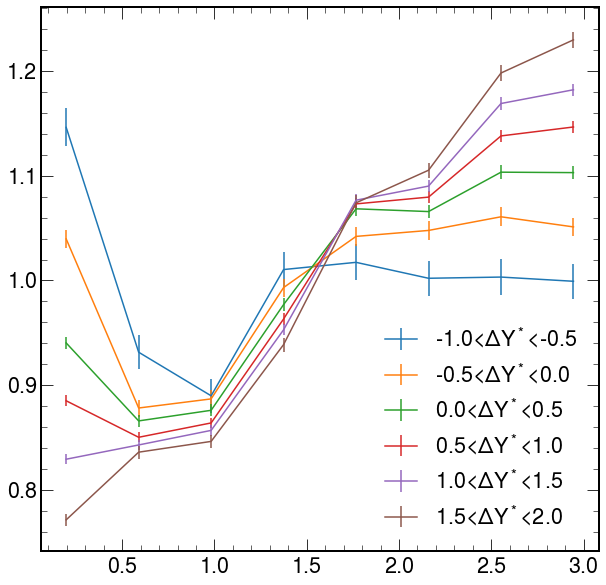

In [319]:
ptmin=0.07
q = f"h1_pid==211 and h1_e3_pt>{ptmin} "+\
                 f" and h2_e3_pt>{ptmin}  and h1_z>0.5 and h2_pid==2212 and h2_p_corr>0.35 and pass_proton_TOF_cut"
q+=" and abs(e_ph-mixevt_e_ph)<10"# and abs(Q2-mixevt_Q2)<.3*Q2"
for i in range(6):
    dfq=df.query(q+ f' and drap_e3-ycm_e3>{i*.5-1} and drap_e3-avg_ycm<{i*.5-.5}')
    y, x=np.histogram(dfq.dphi_e3, range=(0, np.pi), bins=8)
    bc=(x[1:]+x[:-1])/2
    dy=np.sqrt(y)
    plt.errorbar(bc, y*len(y)/sum(y), dy*len(y)/sum(y), label=f'{i*.5-1:.1f}<$\\Delta Y^*$<{i*.5-.5:.1f}')
# dfq=df.query(q)
# y, x=np.histogram(dfq.dphi_e3, range=(0, np.pi), bins=8)
# bc=(x[1:]+x[:-1])/2
# dy=np.sqrt(y)
# plt.errorbar(bc, y*len(y)/sum(y), dy*len(y)/sum(y), label=f'unbinned in $\\Delta Y^*$')
plt.legend()

print("stdev is ", np.std(y*len(y)/sum(y)-1))